# Turn address to lat/long

In [1]:
import mapbox
from mapbox import Geocoder

MAPBOX_ACCESS_KEY = 'pk.eyJ1IjoidGxldWNiIiwiYSI6ImNrN2N3d3h1aTA0YWwzaHFoNGJreDJmY2YifQ.pbWSn9txb4n8fKmUaKAG4g'

def get_loc(address):
    """
    Convert a string of address to latitude and longitude
    Input: String
    Output: latitude, longitude coordinate
    """

    geocoder = mapbox.Geocoder(access_token = MAPBOX_ACCESS_KEY)
    response = geocoder.forward(address)
    address = response.json()
    add_lat = address["features"][0]["center"][1]
    add_lon = address["features"][0]["center"][0]
    return add_lat, add_lon

In [2]:
address = "Berkeley,CA"

In [3]:
%%time
add_lat,add_lon = get_loc(address)
print(add_lat,add_lon)

37.8708 -122.2729
Wall time: 139 ms


# Check if in trained area

In [4]:
from shapely.geometry import Polygon
from shapely.geometry import Point

def chk_polygon(pt_lon, pt_lat):
    """
    This function checks to see if address entered is within the polygon of data the model is trained on
    Input: string
    Output: boolean
    """

    # the coordinates of the polygon
    coords = [(-123.5,39), (-119.5,39), (-119.5,36), (-123.5,36),(-123.5,39)]
    poly_bound = Polygon(coords)

    # check ot see if provided coordinate is within the boundary of the polygon
    point_interest = Point(pt_lon, pt_lat)
    result = point_interest.within(poly_bound)

    return result


In [5]:
%%time
inpolyq = chk_polygon(add_lon,add_lat)
print(inpolyq)

True
Wall time: 1 ms


# Check if active fire nearby

In [62]:
from math import radians, degrees, sin, cos, asin, acos, sqrt
import geopandas as gpd
import numpy as np

def points(poly):
    return list(map(tuple,np.asarray(poly.exterior.coords)))

def great_circle(lat1, lon1, lat2, lon2):
    """
    This function calculates the shortest distance between two sets of coordinates.
    """

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # use 6371 if calculating kilometers (3958.756 for miles)
    return 3958.756 * (acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2)))


def chk_fire(lon_origin, lat_origin):
    """
    Function to find coordinates of active fires of given origin
    Input: latitude, longitude of input address (origin)
    Output: List of active fires within certain miles of origin
    """

    # set variables
    geo_center = []

    # read JSON on active fire
    url = 'https://opendata.arcgis.com/datasets/5da472c6d27b4b67970acc7b5044c862_0.geojson'
    geo_data = gpd.read_file(url)
    poly_list = geo_data.geometry
    geo_poly = []
    fire_num = None

    for i in range(0,len(poly_list)):
        if len(geo_center) > 0:
            break
        if poly_list[i].geom_type == 'MultiPolygon':
            for j in range(0, len(poly_list[i])):
                geo_poly = points(poly_list[i][j])
                for k in range(0, len(geo_poly)):
                    fire_lon = geo_poly[k][0]
                    fire_lat = geo_poly[k][1]
                    dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)
                    if dist <= 100:
                        geo_center = [fire_lon, fire_lat]
                        break
                if len(geo_center) > 0:
                    break
            if len(geo_center) > 0:
                break
        else:
            geo_poly = points(poly_list[i])
            for j in range(0, len(geo_poly)):
                fire_lon = geo_poly[j][0]
                fire_lat = geo_poly[j][1]
                dist = great_circle(lat_origin, lon_origin, fire_lat, fire_lon)
                if dist <= 100:
                    geo_center = [fire_lon, fire_lat]
                    fire_num = i
                    break
            if len(geo_center) > 0:
                break
        if len(geo_center) > 0:
            break
        else:
            geo_poly =[]
            break

    # convert to format for prediction
    geo_poly = [tuple(l) for l in geo_poly]

    return geo_center, geo_poly, fire_num, geo_data

In [67]:
%%time
geo_center, geo_poly, fire_num, geo_data = chk_fire(add_lon, add_lat)

Wall time: 833 ms


In [68]:
print(geo_center)

[]


In [69]:
print(geo_poly)

[]


In [70]:
print(fire_num)

None


In [87]:
fire_num = 0
# firerow = geo_data.iloc[fire_num]
# firerow
fname = geo_data.iloc[fire_num]['IncidentName']
farea = geo_data.iloc[fire_num]['GISAcres']
print(fname,farea)


4 Corners 1.25228814085313


# No Active Fire nearby so go to 'else' on line 738

In [10]:
# Fake Coords
coords = [[-121.91030200875473, 36.49549958363892],[-121.89706675496642, 36.49549958363892],[-121.91471376001749, 36.49132363869813],[-121.89265500370365, 36.49132363869813],[-121.91912551128027, 36.48714769375733],[-121.89706675496642, 36.48714769375733],[-121.92353726254304, 36.48297174881653],[-121.89706675496642, 36.48297174881653],[-121.93236076506857, 36.478795803875734],[-121.88824325244089, 36.478795803875734],[-121.93677251633135, 36.474619858934936],[-121.88824325244089, 36.474619858934936],[-121.9279490138058, 36.47044391399414],[-121.88383150117812, 36.47044391399414],[-121.92353726254304, 36.46626796905334],[-121.91471376001749, 36.46626796905334],[-121.90589025749196, 36.46626796905334],[-121.87941974991534, 36.46626796905334],[-121.9279490138058, 36.46209202411254],[-121.87941974991534, 36.46209202411254],[-121.92353726254304, 36.457916079171746],[-121.86618449612705, 36.457916079171746],[-121.8441257398132, 36.457916079171746],[-121.83971398855043, 36.457916079171746],[-121.92353726254304, 36.45374013423095],[-121.8573609936015, 36.45374013423095],[-121.92353726254304, 36.44956418929015],[-121.85294924233874, 36.44956418929015],[-121.91912551128027, 36.44538824434935],[-121.84853749107596, 36.44538824434935],[-121.9279490138058, 36.441212299408555],[-121.90589025749196, 36.441212299408555],[-121.89265500370365, 36.441212299408555],[-121.87941974991534, 36.441212299408555],[-121.87500799865258, 36.441212299408555],[-121.84853749107596, 36.441212299408555],[-121.83971398855043, 36.441212299408555],[-121.82647873476212, 36.441212299408555],[-121.9279490138058, 36.43703635446776],[-121.90589025749196, 36.43703635446776],[-121.89265500370365, 36.43703635446776],[-121.87059624738981, 36.43703635446776],[-121.86618449612705, 36.43703635446776],[-121.81765523223659, 36.43703635446776],[-121.91471376001749, 36.43286040952696],[-121.89706675496642, 36.43286040952696],[-121.89265500370365, 36.43286040952696],[-121.87500799865258, 36.43286040952696],[-121.86177274486427, 36.43286040952696],[-121.81324348097381, 36.43286040952696],[-121.90589025749196, 36.42868446458617],[-121.89706675496642, 36.42868446458617],[-121.89265500370365, 36.42868446458617],[-121.87059624738981, 36.42868446458617],[-121.85294924233874, 36.42868446458617],[-121.82647873476212, 36.42868446458617],[-121.91030200875473, 36.42450851964537],[-121.87500799865258, 36.42450851964537],[-121.84853749107596, 36.42450851964537],[-121.82647873476212, 36.42450851964537],[-121.90589025749196, 36.420332574704574],[-121.86618449612705, 36.420332574704574],[-121.83971398855043, 36.420332574704574],[-121.82206698349935, 36.420332574704574],[-121.89706675496642, 36.416156629763776],[-121.86177274486427, 36.416156629763776],[-121.83971398855043, 36.416156629763776],[-121.81324348097381, 36.416156629763776],[-121.89265500370365, 36.41198068482298],[-121.87941974991534, 36.41198068482298],[-121.87500799865258, 36.41198068482298],[-121.80883172971104, 36.41198068482298],[-121.89706675496642, 36.40780473988218],[-121.87941974991534, 36.40780473988218],[-121.87500799865258, 36.40780473988218],[-121.80883172971104, 36.40780473988218],[-121.88383150117812, 36.40362879494138],[-121.80000822718551, 36.40362879494138],[-121.88383150117812, 36.399452850000586],[-121.82206698349935, 36.399452850000586],[-121.87941974991534, 36.39527690505979],[-121.82206698349935, 36.39527690505979],[-121.81765523223659, 36.39527690505979],[-121.80441997844828, 36.39527690505979],[-121.87500799865258, 36.39110096011899],[-121.80883172971104, 36.39110096011899],[-121.86177274486427, 36.38692501517819],[-121.80441997844828, 36.38692501517819],[-121.8573609936015, 36.382749070237395],[-121.85294924233874, 36.382749070237395],[-121.8441257398132, 36.382749070237395],[-121.83530223728766, 36.382749070237395],[-121.83971398855043, 36.3785731252966],[-121.82647873476212, 36.3785731252966],[-121.86618449612705, 36.361869345533414],[-121.86177274486427, 36.361869345533414],[-121.80441997844828, 36.361869345533414],[-121.80000822718551, 36.361869345533414],[-121.79559647592274, 36.361869345533414],[-121.79118472465997, 36.361869345533414],[-121.82206698349935, 36.357693400592616],[-121.81765523223659, 36.357693400592616],[-121.8573609936015, 36.34516556577022],[-121.85294924233874, 36.34516556577022]]

## Get the Geo_polygon

In [92]:
%%time
geo_poly = [tuple(l) for l in coords]

Wall time: 0 ns


In [108]:
from shapely.geometry import Polygon
coordpoly = Polygon(geo_poly)

In [112]:
import shapely.ops as ops
import pyproj
from functools import partial

polyarea = ops.transform(
    partial(
        pyproj.transform,
        pyproj.Proj(init='EPSG:4326'),
        pyproj.Proj(
            proj='aea',
            lat_1=coordpoly.bounds[1],
            lat_2=coordpoly.bounds[3])),
    coordpoly)

area = polyarea.area
print(area,"m2")

22218767.448180243 m2


C:\DDRIVE\ProgramFiles\Anaconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\DDRIVE\ProgramFiles\Anaconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [113]:
acres = area*0.000247105
acres

5490.36853028258

## Get predictions for input polygon

### Setup

In [12]:
import boto3
import io
import pickle
import requests
import datetime
import os
import pandas as pd
import itertools
import keras

Using TensorFlow backend.


In [13]:
%%time
s3_client = boto3.client('s3')
bucket_name = 'hotzone'

Wall time: 206 ms


### Pull configuration and weights from S3

In [14]:
def pull_data_from_s3(s3_client, bucket_name, key_name):
    '''
    Pulls pre-processed data from S3.

    Args:
        - s3_client: boto3 s3 client
        - bucket_name: name of bucket on s3 to pull data from
        - key_name: directory/file_name to pull data from
    Returns:
        - Nothing

    https://stackoverflow.com/questions/48049557/how-to-write-npy-file-to-s3-directly
    '''

    array_data = io.BytesIO()
    s3_client.download_fileobj(bucket_name, key_name, array_data)

    array_data.seek(0)
    array = pickle.load(array_data)

    return array

In [15]:
%%time
new_config = pull_data_from_s3(s3_client, bucket_name, 'models/model_config.pickle')

Wall time: 637 ms


In [16]:
%%time
new_weights = pull_data_from_s3(s3_client, bucket_name, 'models/model_weights.pickle')

Wall time: 451 ms


### Pull Weather Maxes from S3

In [17]:
def pull_weather_maxes_from_s3():
    '''
    Pull files from S3 for the provided year and save to local directory
    '''
    s3 = boto3.resource('s3')

    key = "BayAreaWeather/max_values/max_values.pickle"
    directory = 'static/'
    path = directory + 'max_values.pickle'

    s3.Bucket('hotzone').download_file(key, path)

    total_path = os.path.abspath(directory)

    for f in os.listdir(total_path):
        if f.endswith('.pickle'):
            max_values = total_path + '/' + f

    max_values = pd.read_pickle(max_values)

    return max_values

In [18]:
%%time
max_values = pull_weather_maxes_from_s3()

Wall time: 740 ms


### First part of prediction algorithm

In [19]:
def get_index(long,lat):

    '''
    Get the pixel of a given coordinate.

    Args:
        - Long: longitude of point
        - Lat: latitude of point
    Returns:
        - pixelrow: index of row of point
        - pixelcol: index of column of point

    '''

    left = -123.50294421461426
    top = 39.00106654811723

    xres = 0.004411751262768785
    yres = -0.0041759449407971815

    pixelcol = int(np.rint((long - left)/xres))
    pixelrow = int(np.rint((lat - top)/yres))

    return (pixelrow, pixelcol)

In [20]:
def predict_day_p1(lat_long_coords,day=1):
    
    today = np.zeros((719, 908))
    side = 16

    for (long, lat) in lat_long_coords:
        index = get_index(long,lat)
        today[index] = 1

    np.pad(today, pad_width=32, mode='constant', constant_values=0)

    fire_vals = np.where(today == 1)

    x_avg = int(np.mean(fire_vals[0]))
    y_avg = int(np.mean(fire_vals[1]))

    x_min = x_avg - 50
    x_max = x_avg + 50

    x_min = max(x_min, 0)
    x_max = min(x_max, 972)

    y_min = y_avg - 50
    y_max = y_avg + 50

    y_min = max(y_min, 0)
    y_max = min(y_max, 783)

    x_vals = range(x_min, x_max)
    y_vals = range(y_min, y_max)

    vals = list(itertools.product(x_vals, y_vals))
    
    return (x_avg,y_avg,vals,today,side)

In [21]:
%%time
x_avg,y_avg,vals,today,side = predict_day_p1(geo_poly,1)

Wall time: 11.5 ms


### Second part of prediction algorithm where we get the weather for the average point

In [22]:
def get_coords(y, x):

    '''
    Get the coordinates of a given pixel in the tif coordinate system.

    Args:
        - Y: index of row of point
        - X: index of column of point
    Returns:
        - Long: longitude of point
        - Lat: latitude of point
    '''

    left = -123.50294421461426
    top = 39.00106654811723

    xres = 0.004411751262768785
    yres = -0.0041759449407971815

    deltax = xres*x
    deltay = yres*y

    long = left+deltax
    lat = top+deltay

    return (long, lat)

In [23]:
%%time
(long, lat) = get_coords(x_avg, y_avg)

Wall time: 0 ns


In [24]:
def get_weather(max_values, lat, long, day):

    '''
    Get tomorrow's weather forecast for fire prediction.

    Args:
        - Max_values: list of weather max_values used to scale weather
        - Lat: latitude of point to fetch weather for
        - Long: longitude of point to fetch weather for
    Returns:
        - weather: a list of weather data to use for prediction
    '''


    s = requests.Session()
    s.auth = ('user', 'pass')
    s.headers.update({'Accept-Encoding':'gzip'})
    headers = {'Accept-Encoding':'gzip'}

    key = '5ffac5f056d341c6296cba58fa96e9ba'
    date = str(datetime.date.today() + datetime.timedelta(days = day)) + 'T12:00:00'
    lat = str(lat,)
    long = str(long)
    blocks = '[currently,minutely,hourly,alerts]'
    units = 'ca'

    # set the query string for darksky
    query = ('https://api.darksky.net/forecast/'+key+'/'+
    lat+','+long+','+date+'?exclude='
    +blocks+'&units='+units)

    # Make the call to Dark Sky to get all the data for that date and location
    r = s.get(query,headers=headers)

    data = r.json()
    data = data['daily']['data'][0]

    rainint = data['precipIntensityMax']
    high_t = data['temperatureHigh']
    low_t= data['temperatureLow']
    humidity = data['humidity']
    wind_speed = data['windSpeed']
    wind_direction = data['windBearing']

    weather_data = {
        'rainint': rainint,
        'High T': high_t+273.15,
        'Low T': low_t+273.15,
        'Humidity': humidity,
        'Wind Speed': wind_speed,
        'Wind Direction': wind_direction
    }

    weather = []

    for k, v in weather_data.items():
        max_val = max_values.get(k, 1)

        val = v/float(max_val)
        weather.append(val)

    return weather

In [25]:
%%time
day=1
weather = get_weather(max_values, lat, long, day)

weather_data {'rainint': 0.0381, 'High T': 284.67999999999995, 'Low T': 280.71, 'Humidity': 0.92, 'Wind Speed': 7.46, 'Wind Direction': 274}
Wall time: 303 ms


### 3rd part of prediction algorithm - actually running the prediction

In [48]:
def predict_day_p3(new_config,new_weights,today,vals,weather,side):
    
    # Need this line to run on Laura's Machine
    #keras.backend.tensorflow_backend._SYMBOLIC_SCOPE.value=True
    #  Comment out for server if needed
    import time

    model = keras.Model.from_config(new_config)
    model.set_weights(new_weights)
    
    #values = []

    shape = today.shape
    prediction = np.zeros(shape)
    
    times=np.zeros(shape)
    for (xi, yi) in vals:

        point = (xi, yi)

        xi_r = int(xi + side)
        xi_l = int(xi - side)
        yi_b = int(yi + side)
        yi_t = int(yi - side)
        
        if xi_r > 0 and xi_l > 0 and yi_b > 0 and yi_t > 0:

            m = today[xi_l:xi_r, yi_t:yi_b]

            if (m.shape == (32, 32)):
                fire = []
                w = []

                fire.append(np.asarray(m))
                w.append(np.asarray(weather))

                fire = np.asarray(fire)
                w = np.asarray(w)

                obs = len(fire)
                fire = fire.reshape(obs, 32, 32, 1)
                
                st = time.monotonic_ns()
                val = model.predict([fire, w])
                et = time.monotonic_ns()

                prediction[point] = val
                times[point]=(et-st)
        
    outline = np.rint(prediction)
    outline = np.diff(outline)
    outline = np.abs(outline)
    
    return (outline,times)

In [27]:
%%time
outline,times=predict_day_p3(new_config,new_weights,today,vals,weather,side)

Wall time: 16 s


times for whole loop predict ste (early version)
get model time = 0.13748407363891602  
predict loop time= 14.675502300262451  
reformatting matrix time= 0.013500213623046875  
Wall time: 14.8 s

#### distribution of prediction times

In [49]:
mxt=np.amax(times)
mnt=np.amin(times)
print(mxt,mnt)

141000000.0 0.0


In [29]:
times.shape

(719, 908)

In [30]:
times2=times.flatten()

In [31]:
times2.shape

(652852,)

In [32]:
z=np.amax(times2)
print(z/1000000000.0)

0.141


In [33]:
g=np.sum(times2)
print(g/1000000000.0)

15.474


In [34]:
t3 = times2/1000000000.0
h = np.sum(t3)
print(h)

15.474


In [35]:
t4 = t3[t3>0]

In [36]:
t4.shape

(982,)

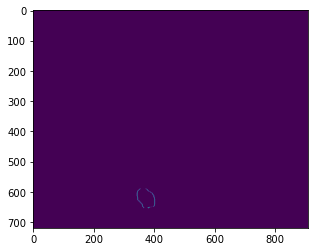

In [38]:
import matplotlib.pyplot as plt
plt.imshow(outline)

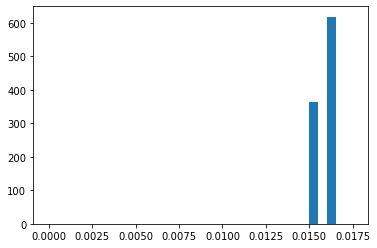

In [39]:
plt.hist(t4,bins=[0,0,0.0150,0.0155,0.016,0.0165,0.017,0.0175])
plt.show()

### 4th part of prediction algorithm 

In [40]:
def predict_day_p4(outline):
    # get pixels from outline
    poly_to_plot = np.where(outline != 0)

    # instantiate a matrix in the target shape
    shape = outline.shape
    poly = np.zeros(shape)

    # create a list of coordinates in the tif coordinate system
    tif_coordinates = []

    for (xi, yi) in list(zip(poly_to_plot[0], poly_to_plot[1])):
        poly[xi,yi] = 1
        coords = get_coords(xi, yi)
        tif_coordinates.append(coords)

    return tif_coordinates

In [41]:
%%time
tif_coords = predict_day_p4(outline)

Wall time: 6 ms


In [42]:
print(len(tif_coords))

134


### Total Prediction algorithm

In [43]:
def predict_day(lat_long_coords, day=1):
    """
    Predict where fire will be in the next day.
    Args:
        - lat_long_coords: a list of lat/long coordinates that make up a polygon representing where fire is
    Returns:
        - prediction: a list of lat/long coordinates that make up a polygon representing where fire will be
    """

    # load model from s3

    new_config = pull_data_from_s3(s3_client, bucket_name, 'models/model_config.pickle')
    new_weights = pull_data_from_s3(s3_client, bucket_name, 'models/model_weights.pickle')

    # Need this line to run on Laura's Machine
    #keras.backend.tensorflow_backend._SYMBOLIC_SCOPE.value=True
    #  Comment out for server if needed

    model = keras.Model.from_config(new_config)
    model.set_weights(new_weights)

    today = np.zeros((719, 908))
    side = 16

    for (long, lat) in lat_long_coords:
        index = get_index(long,lat)
        today[index] = 1

    np.pad(today, pad_width=32, mode='constant', constant_values=0)

    fire_vals = np.where(today == 1)

    x_avg = int(np.mean(fire_vals[0]))
    y_avg = int(np.mean(fire_vals[1]))

    x_min = x_avg - 50
    x_max = x_avg + 50

    x_min = max(x_min, 0)
    x_max = min(x_max, 972)

    y_min = y_avg - 50
    y_max = y_avg + 50

    y_min = max(y_min, 0)
    y_max = min(y_max, 783)


    x_vals = range(x_min, x_max)
    y_vals = range(y_min, y_max)

    vals = list(itertools.product(x_vals, y_vals))

    values = []

    shape = today.shape
    prediction = np.zeros(shape)

    (long, lat) = get_coords(x_avg, y_avg)

    # get max weather values
    max_values = pull_weather_maxes_from_s3()

    weather = get_weather(max_values, lat, long, day)

    for (xi, yi) in vals:

        point = (xi, yi)

        xi_r = int(xi + side)
        xi_l = int(xi - side)
        yi_b = int(yi + side)
        yi_t = int(yi - side)

        if xi_r > 0 and xi_l > 0 and yi_b > 0 and yi_t > 0:

            m = today[xi_l:xi_r, yi_t:yi_b]

            if (m.shape == (32, 32)):
                fire = []
                w = []

                fire.append(np.asarray(m))
                w.append(np.asarray(weather))

                fire = np.asarray(fire)
                w = np.asarray(w)

                obs = len(fire)
                fire = fire.reshape(obs, 32, 32, 1)

                val = model.predict([fire, w])

                prediction[point] = val

    outline = np.rint(prediction)
    outline = np.diff(outline)
    outline = np.abs(outline)

    # get pixels from outline
    poly_to_plot = np.where(outline != 0)


    # instantiate a matrix in the target shape
    shape = outline.shape
    poly = np.zeros(shape)

    # create a list of coordinates in the tif coordinate system
    tif_coordinates = []

    for (xi, yi) in list(zip(poly_to_plot[0], poly_to_plot[1])):
        poly[xi,yi] = 1
        coords = get_coords(xi, yi)
        tif_coordinates.append(coords)

    return tif_coordinates

In [44]:
%%time
predict_day1 = predict_day(geo_poly, 1)

weather_data {'rainint': 0.0381, 'High T': 284.67999999999995, 'Low T': 280.71, 'Humidity': 0.92, 'Wind Speed': 7.46, 'Wind Direction': 274}
Wall time: 18.7 s


In [45]:
print(len(predict_day1))

134


## Map output of prediction

In [46]:
map_output_day1 = [list(row) for row in predict_day1] # to convert to format for mapbox

In [47]:
map_output_day1

[[-121.94559601885688, 36.54143497798769],
 [-121.86177274486427, 36.54143497798769],
 [-121.95000777011965, 36.537259033046894],
 [-121.8573609936015, 36.537259033046894],
 [-121.95441952138242, 36.533083088106096],
 [-121.8441257398132, 36.533083088106096],
 [-121.95883127264518, 36.5289071431653],
 [-121.8441257398132, 36.5289071431653],
 [-121.96765477517073, 36.5247311982245],
 [-121.83971398855043, 36.5247311982245],
 [-121.9720665264335, 36.5205552532837],
 [-121.83530223728766, 36.5205552532837],
 [-121.97647827769626, 36.516379308342906],
 [-121.83089048602488, 36.516379308342906],
 [-121.97647827769626, 36.51220336340211],
 [-121.82647873476212, 36.51220336340211],
 [-121.9853017802218, 36.50802741846131],
 [-121.82647873476212, 36.50802741846131],
 [-121.9853017802218, 36.50385147352051],
 [-121.80441997844828, 36.50385147352051],
 [-121.9853017802218, 36.499675528579715],
 [-121.80441997844828, 36.499675528579715],
 [-121.9853017802218, 36.49549958363892],
 [-121.7911847246

# Getting Active fires for the table

In [56]:
def active_fire():
    """
    Function to find coordinates of all current active fires from url
    Input: N/A
    Output: List of tuples of active fires
    """
    import re
    import time

    # set variables
    lat_geo = []
    lon_geo = []
    geo_fire = []

    # list of the States in USA
    states = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota','South Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']

    st1 = time.time()
    # read JSON on active fire
    url = 'https://opendata.arcgis.com/datasets/5da472c6d27b4b67970acc7b5044c862_0.geojson'
    et1 = time.time()
    print("time to request firedata", (et1-st1))
    # geo_data = requests.get(url).json()
    geo_data = gpd.read_file(url)

    poly_list = geo_data.geometry

    # grab the first coordinates of all polygons to create list of active fires
    st2 = time.time()
    for m in range(0,len(poly_list)):

        if poly_list[m].geom_type == 'MultiPolygon':

            geo_poly = points(poly_list[m][0])

            fire_lon = geo_poly[0][0]
            fire_lat = geo_poly[0][1]

            lat_geo.append(fire_lat)
            lon_geo.append(fire_lon)

        else:

            geo_poly = points(poly_list[m])

            fire_lon = geo_poly[0][0]
            fire_lat = geo_poly[0][1]

            lat_geo.append(fire_lat)
            lon_geo.append(fire_lon)

    geo_fire = [[a, b] for a, b in zip(lon_geo, lat_geo)]
    et2 = time.time()
    print('time to get first coords of fires for list',(et2-st2))
    #
    fire_names = geo_data.IncidentName
    acres = geo_data.GISAcres

    geocoder = mapbox.Geocoder(access_token = MAPBOX_ACCESS_KEY)

    loc_output = []
    state_output = []
    st3 = time.time()
    for l in range(0,len(geo_fire)):

        rev_lon = geo_fire[l][0]
        rev_lat = geo_fire[l][1]

        response = geocoder.reverse(lon=rev_lon, lat=rev_lat)

        features = response.geojson()['features']

        loc_name = features[0]["place_name"]

        loc_output.append(loc_name)

        result = loc_name.split(",")

        for s in range(0,len(result)):
            res = result[s]
            res1 = re.sub(r'[0-9]+', '',res)
            res2 = res1.strip()
            if res2 in states:
                state_output.append(res2)
                break

    firename = []

    for f in range(0,len(fire_names)):
        firename.append(fire_names[f])

    fireacre = []

    for a in range(0,len(acres)):
        fireacre.append(acres[a])
    et3 = time.time()
    print("time to extract data for table, includes 3 loops through list", (et3-st3))
    
    st4 = time.time()
    firestate = pd.Series(state_output)

    fireloc = pd.Series(loc_output)

    firename = pd.Series(firename)

    fireacre = pd.Series(fireacre)

    df = {"State": firestate, "Active Fire Name": firename, "Approximate Fire Location": fireloc, "Acre Burned": fireacre }

    fire_table = pd.DataFrame(df)

    fire_table = fire_table.sort_values(by=["State"])

    fire_table = fire_table.reset_index(drop=True)

    fire_table.index = fire_table.index + 1
    et4 = time.time()
    print("time to create dataframes for table",(et4-st4))
    return geo_fire, fire_table

In [57]:
%%time
geo_fire, fire_table = active_fire()

time to request firedata 0.0
time to get first coords of fires for list 0.023500442504882812
time to extract data for table, includes 3 loops through list 1.23008394241333
time to create dataframes for table 0.002999544143676758
Wall time: 2.1 s
